# Ethnicity and ONS Covid Deaths

In [1]:
import sys
sys.path.insert(0, '../src/data')
import pandas as pd
import geopandas as gpd
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
import bame_datastore
bame_datastore.lib

Found local clean copy of Local_Authority_Districts__December_2009__Boundaries
Found local clean copy of fbook_covid_cases
Found local clean copy of BAME_report_cases
Found local clean copy of BAME_report_deaths
Found local clean copy of bame_excess_deaths
Found local clean copy of ons_deaths
Found local clean copy of ethnicity_2011
Found local clean copy of furlough_data
Found local clean copy of key_workers
Found local clean copy of deprivation_data
Found local clean copy of population_est_data


{'mortality': ['fbook_covid_data',
  'bame_rpt_deaths',
  'bame_rpt_excess_deaths',
  'ons_deaths'],
 'explanatory': ['ethnicity_data',
  'bame_rpt_cases',
  'furlough_data',
  'key_workers',
  'deprivation',
  'pop_est'],
 'other': ['lad_geog']}

In [3]:
#importing and cleaning our main dataset
ons_deaths_df = bame_datastore.ons_deaths.df # import ons mortality data
ethnicity_df = bame_datastore.ethnicity_data.df # import 2011 census data
ethnicity_list = ethnicity_df.columns[2:]
df = ons_deaths_df.join(ethnicity_df) # join by local authority

pop_df = bame_datastore.pop_est.df.copy() # import 2020 population estimates
df = df.join(pop_df.drop(columns = pop_df.columns[3:])) 
df.rename(columns={"All ages": "total_pop"}, inplace=True)
df["covid_Deaths_pop"] = df["covid_Deaths"]/df["total_pop"] # normalise deaths by population

df = df.drop(columns = ["Sex", "Geography", "Area code", "all Lower CI", "all Upper CI", "covid Lower CI",
                   "covid Upper CI", "Geography_code", "Denominator", "Code", "Geography1"])
df.head()

,all_Deaths,all_Rate,covid_Deaths,covid_Rate,Arab,Asian,Asian Other,Bangladeshi,Black,Black African,...,Other,Other ethnic group,Pakistani,White,White British,White Gypsy or Irish Traveller,White Irish,White Other,total_pop,covid_Deaths_pop
Adur,110,144.3,9,12.1,0.28,1.73,0.42,0.44,0.51,0.39,...,0.43,0.15,0.09,95.88,92.91,0.20,0.70,2.08,64301.0,0.000140
Allerdale,185,155.4,34,28.4,0.00,0.49,0.15,0.09,0.08,0.04,...,0.06,0.06,0.04,98.92,97.58,0.01,0.25,1.08,97761.0,0.000348
Amber Valley,211,153.4,39,27.7,0.02,0.76,0.18,0.01,0.21,0.10,...,0.10,0.08,0.07,98.13,96.47,0.04,0.35,1.28,128147.0,0.000304
Aneurin Bevan University Health Board,1058,181.2,259,44.6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arun,285,119.1,20,8.5,0.05,1.42,0.49,0.25,0.36,0.21,...,0.16,0.12,0.07,97.06,91.64,0.11,0.59,4.71,160758.0,0.000124


In [4]:
def reg_plot(df, cov_death_col):
    """Takes in DataFrame and name of covid death column"""
    fig, ax = plt.subplots(figsize=(20,10))

    corr_capture = {}
    for i in ethnicity_list: #itterate throught the ethnicities
        correlation = df[cov_death_col].corr(df[i])
        corr_capture[i] = correlation

        ax = sns.regplot(x=i, y=cov_death_col, data=df, label=i)

    ax.legend()
    plt.legend(loc='upper right')
    ax.set_title(f'Relationship between {cov_death_col} and ethnicity broken down by Local Authority District')
    ax.set_xlabel('% of local population in this ethnic group - 2011 Census')
    ax.set_ylabel('number of deaths in the local authority district')

    plt.savefig(f"../reports/figures/regplot{cov_death_col}.png")

## Covid Deaths 
**Not** normalising for population


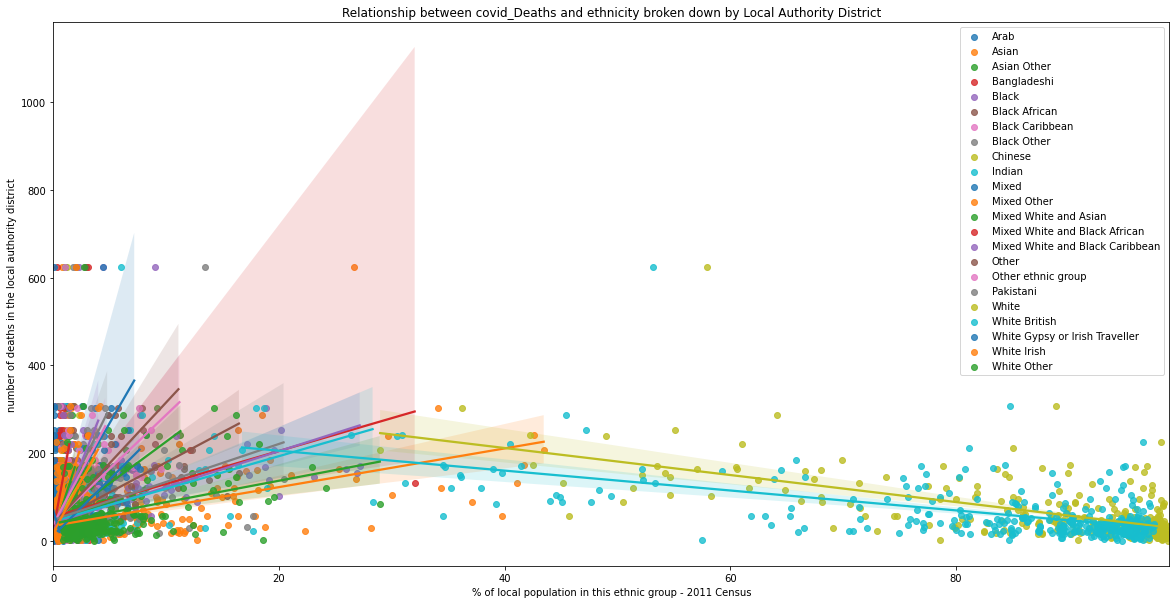

In [5]:
reg_plot(df, "covid_Deaths")

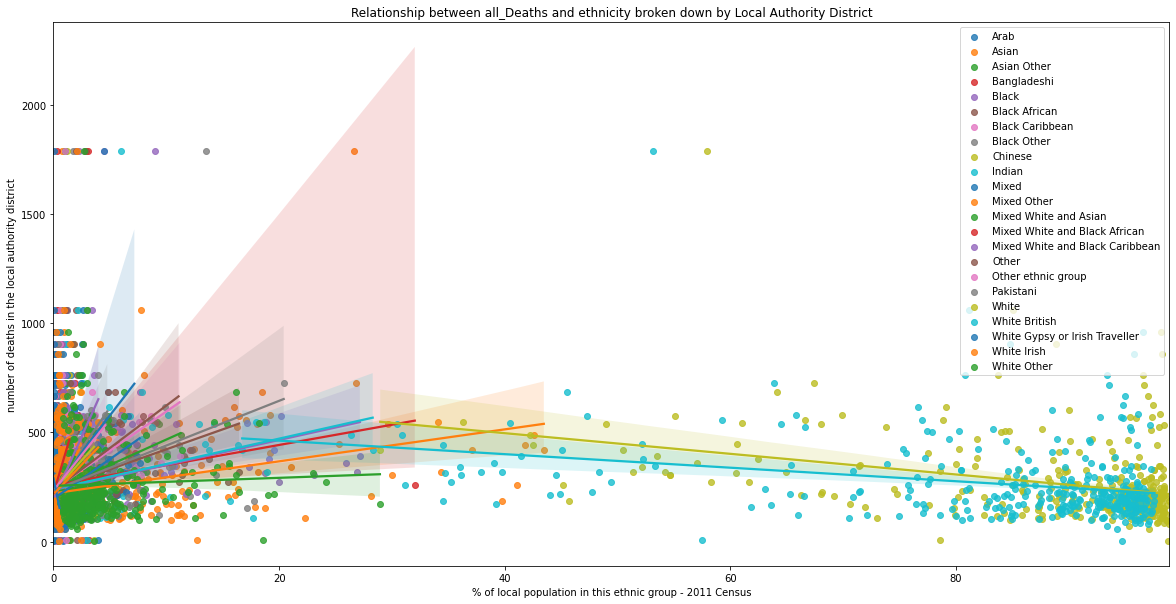

In [6]:
reg_plot(df, "all_Deaths")

## Covid Deaths Normalising for Population
Using population estimated for [mid April 2020](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland)



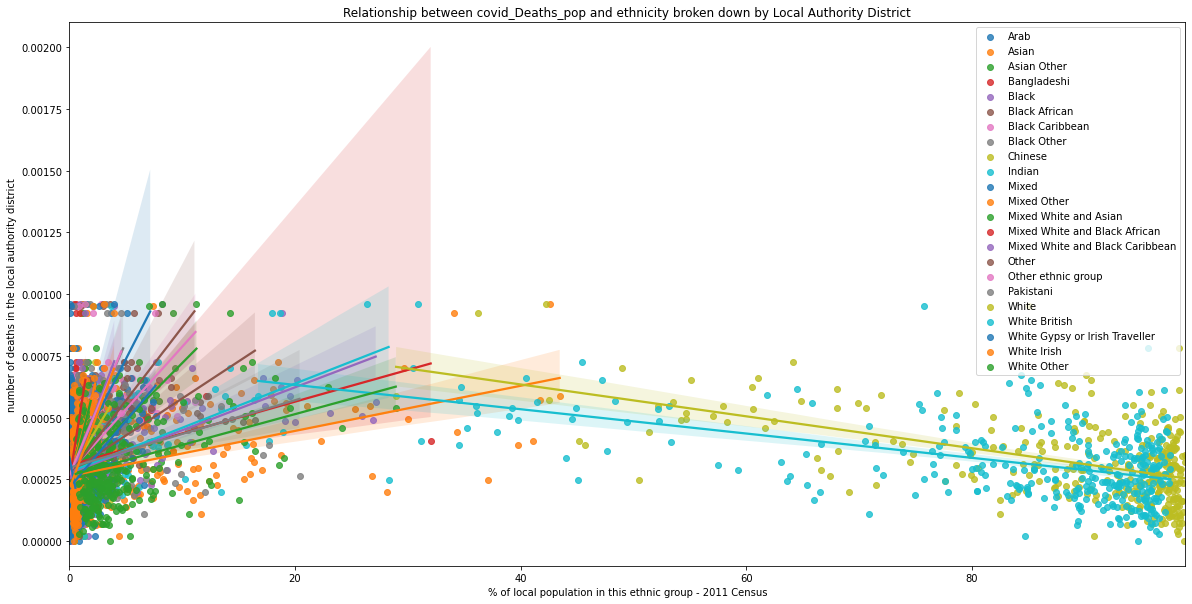

In [7]:
reg_plot(df, "covid_Deaths_pop")

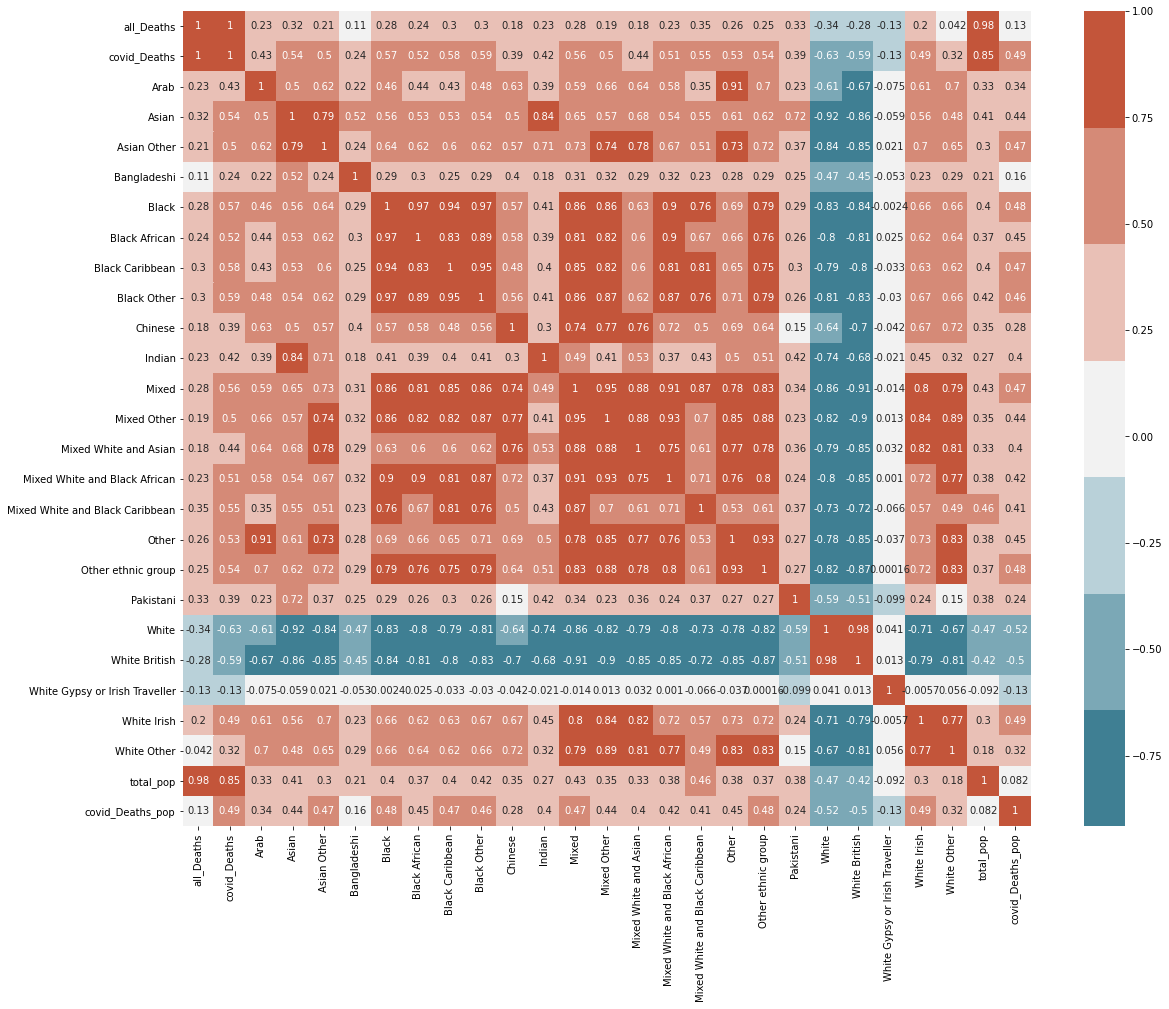

In [8]:
#correlation matrix of relevant variables
plt.figure(figsize=(19, 15))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat.png")

# Grouping Ethnicities
Grouping ethnicities based on the [5 broad ethnic groups](https://www.ethnicity-facts-figures.service.gov.uk/ethnic-groups) used by the goverment. However in doing so we are already losing the heterogeneity wthin these broad categories and may be missing the differing impacts within them.  

In [9]:
df_grouped = df.copy() # target data
df_grouped = df_grouped.drop(columns = ethnicity_list)
# sum groups to get total share
df_grouped["White"] = df[['White', 'White British','White Gypsy or Irish Traveller', 'White Irish', 'White Other']].sum(axis=1)
df_grouped["Mixed"] = df[['Mixed White and Black Caribbean','Mixed White and Asian',
                          'Mixed White and Black African', 'Mixed', 'Mixed Other', ]].sum(axis=1)
df_grouped["Black_African_Caribbean"] = df[['Black', 'Black African', 'Black Caribbean', 'Black Other']].sum(axis=1)
df_grouped["Asian"] = df[['Asian', 'Asian Other', 'Bangladeshi','Chinese','Indian', 'Pakistani', ]].sum(axis=1)
df_grouped["Other"] = df[[ 'Arab','Other', 'Other ethnic group', ]].sum(axis=1)

In [10]:
df_grouped.columns

Index(['all_Deaths', 'all_Rate', 'covid_Deaths', 'covid_Rate', 'total_pop',
       'covid_Deaths_pop', 'White', 'Mixed', 'Black_African_Caribbean',
       'Asian', 'Other'],
      dtype='object')

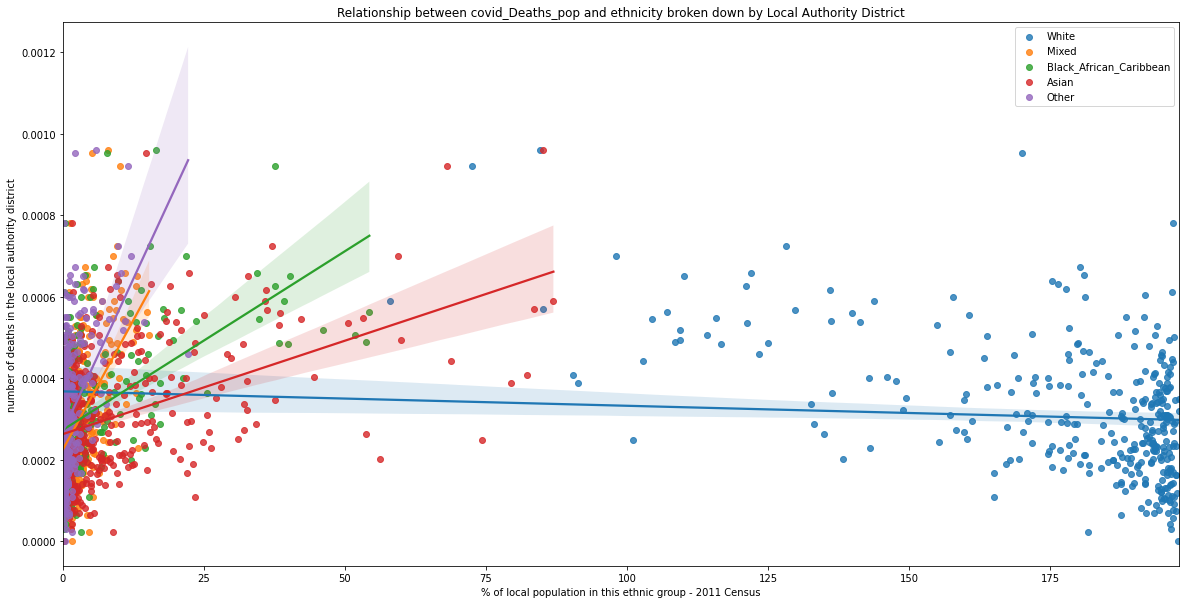

In [11]:
def reg_plot_alt(df, cov_death_col):
    """Takes in DataFrame and name of covid death column"""
    fig, ax = plt.subplots(figsize=(20,10))

    corr_capture = {}
    for i in df_grouped.columns[6:]: #itterate throught the ethnicities
        correlation = df[cov_death_col].corr(df[i])
        corr_capture[i] = correlation

        ax = sns.regplot(x=i, y=cov_death_col, data=df, label=i)

    ax.legend()
    plt.legend(loc='upper right')
    ax.set_title(f'Relationship between {cov_death_col} and ethnicity broken down by Local Authority District')
    ax.set_xlabel('% of local population in this ethnic group - 2011 Census')
    ax.set_ylabel('number of deaths in the local authority district')

    plt.savefig(f"../reports/figures/regplot{cov_death_col}grouped.png")

reg_plot_alt(df_grouped, "covid_Deaths_pop")


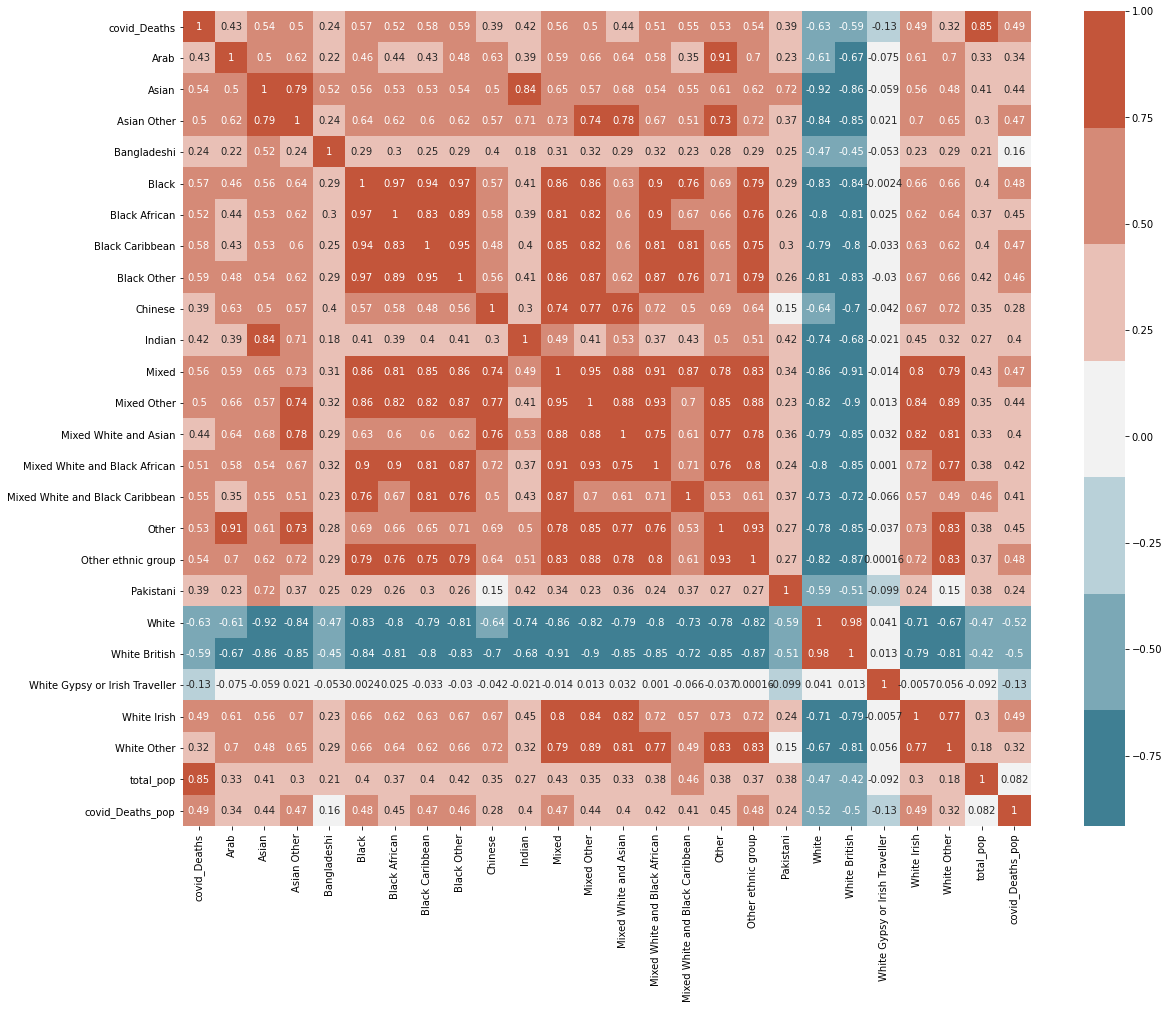

In [12]:
#correlation matrix of relevant variables
df_cor = df.drop(columns=["all_Deaths"])
plt.figure(figsize=(19, 15))
corrMatrix = df_cor.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat_grouped.png")




## Deprivation and Furlough

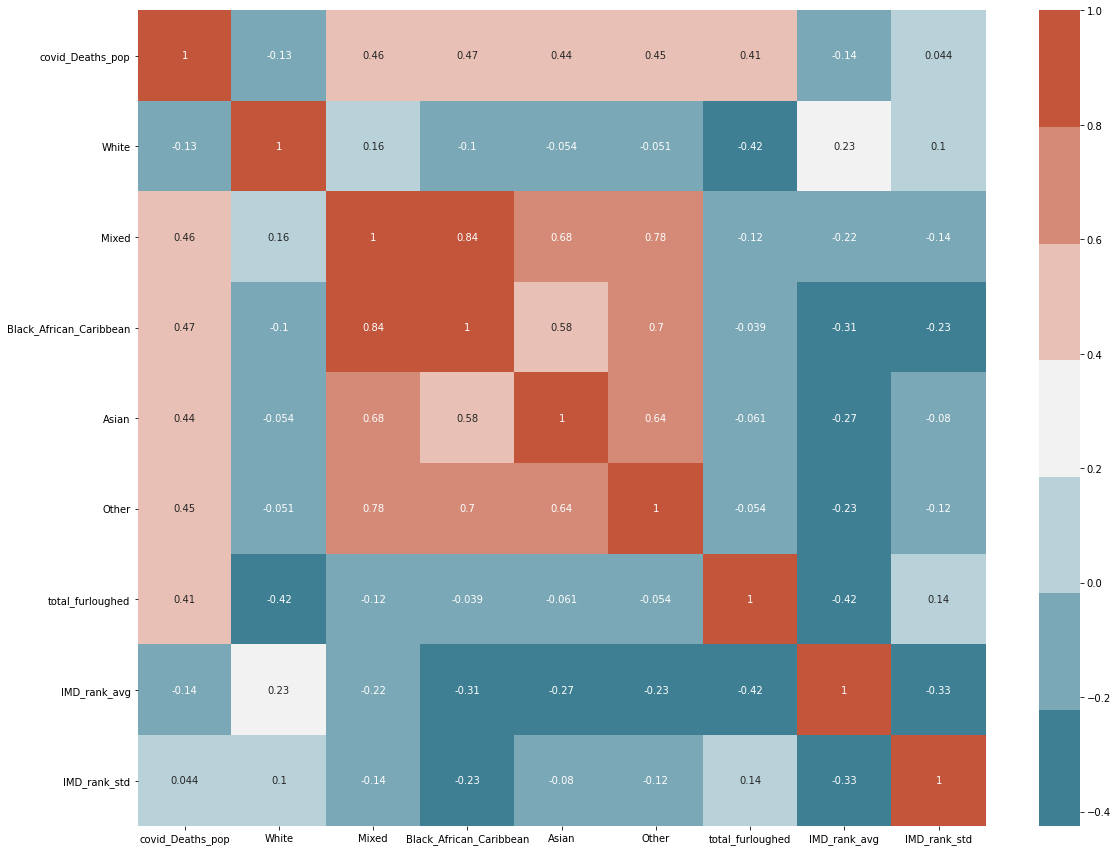

In [46]:
# Adding Furlough
furlough_df = df_grouped.join(bame_datastore.furlough_data.df)
furlough_df = furlough_df.drop(columns=['Area Code', 'all_Deaths', 'all_Rate', 'covid_Deaths','covid_Rate', 'total_pop'])


# Adding Deprivation measures
deprv_df = bame_datastore.deprivation.df.copy()
deprv_df = deprv_df.drop(columns=['IMD_decile_avg', 'IMD_decile_std'])
dep_fur_df = furlough_df.join(deprv_df)
dep_fur_df

plt.figure(figsize=(19, 15))
corrMatrix = dep_fur_df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
plt.savefig("../reports/figures/furlough_deprivation_cormat.png")

## Population Density
Calculate population density of local authorities, using the [size of polygons](https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas)
cross refrencing from the [GLA density estimates](https://data.gov.uk/dataset/a76f46f9-c10b-4fe7-82f6-aa928471fcd1/land-area-and-population-density-ward-and-borough) show this calculation is off by a consistent factor of 2.56 

In [14]:
la_gdf = bame_datastore.lad_geog.gdf.copy()
la_gdf = la_gdf.to_crs({'init': 'epsg:3395'}) # change projection to Cartesian 
la_gdf["area"] = la_gdf['geometry'].area/ 10**6 # area in square km
la_gdf.columns

/Users/yusufsohoye/pythoncode/covid_bame/venv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Index(['objectid', 'lad09cd', 'lad09nm', 'lad09nmw', 'st_areashape',
       'st_lengthshape', 'geometry', 'area'],
      dtype='object')

In [87]:
furlough_df.columns

Index(['covid_Deaths_pop', 'White', 'Mixed', 'Black_African_Caribbean',
       'Asian', 'Other', 'total_furloughed'],
      dtype='object')

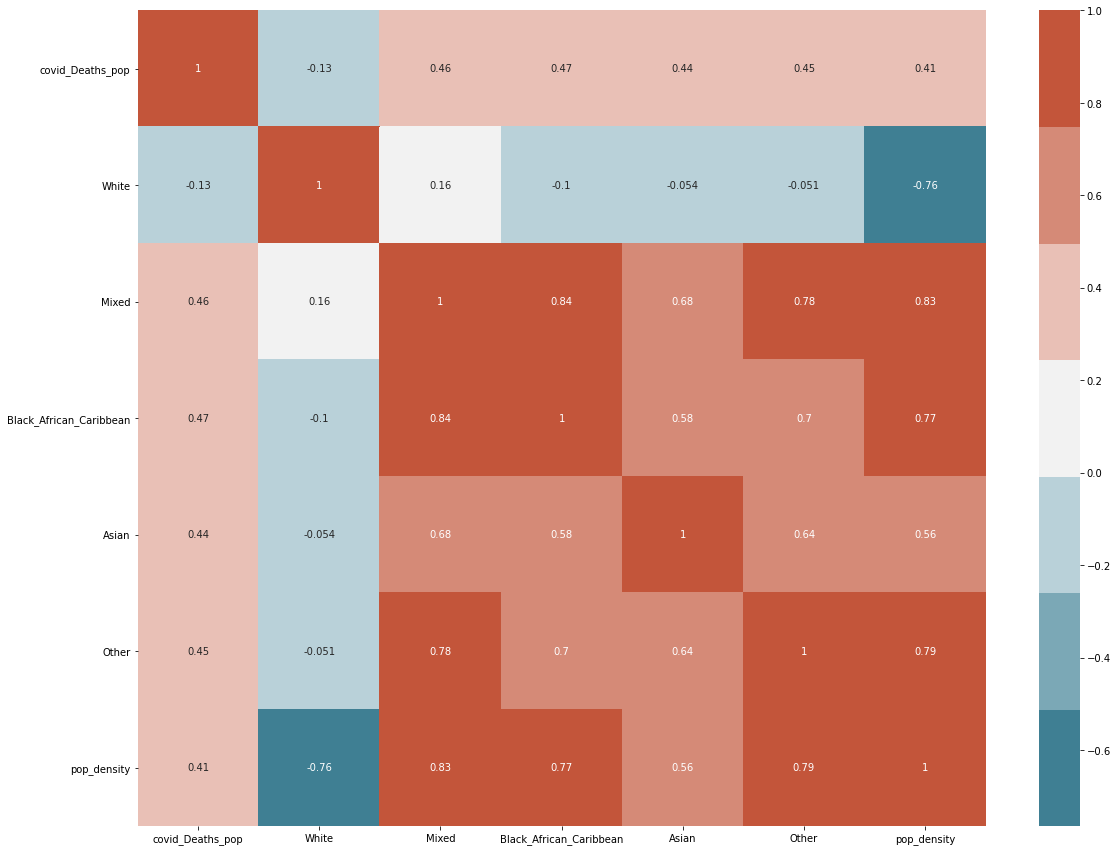

In [90]:
dense_df = df_grouped.join(la_gdf.set_index("lad09nm"))
dense_df["pop_density"] = dense_df["total_pop"]/dense_df["area"]
dense_df = dense_df.drop(columns=["all_Deaths", "covid_Deaths", "area", "total_pop",
                                  'objectid', 'lad09cd', 'lad09nmw', 'st_areashape','st_lengthshape',])

plt.figure(figsize=(19, 15))
corrMatrix = dense_df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
plt.savefig("../reports/figures/density_corrmat.png")

# Regression
Caution advised

In [49]:
dense_df

,all_Rate,covid_Rate,covid_Deaths_pop,White,Mixed,Black_African_Caribbean,Asian,Other,geometry,pop_density
Adur,144.3,12.1,0.000140,191.77,2.91,1.02,3.46,0.86,"MULTIPOLYGON (((-38863.996 6564186.691, -40586...",615.410213
Allerdale,155.4,28.4,0.000348,197.84,0.89,0.15,0.98,0.12,"MULTIPOLYGON (((-353623.422 7315578.458, -3546...",26.078822
Amber Valley,153.4,27.7,0.000304,196.27,1.61,0.42,1.52,0.20,"POLYGON ((-152914.032 6968776.362, -155063.346...",175.339314
Aneurin Bevan University Health Board,181.2,44.6,NaN,0.00,0.00,0.00,0.00,0.00,None,NaN
Arun,119.1,8.5,0.000124,194.11,2.01,0.72,2.84,0.33,"MULTIPOLYGON (((-68726.995 6571423.075, -70537...",289.911570
...,...,...,...,...,...,...,...,...,...,...
Wycombe,137.2,29.6,NaN,162.51,5.65,6.92,23.98,0.93,"POLYGON ((-82002.233 6715941.378, -84012.845 6...",NaN
Wyre,128.3,12.4,0.000178,196.47,1.24,0.24,1.83,0.20,"MULTIPOLYGON (((-301601.529 7128089.879, -3023...",138.771320
Wyre Forest,168.6,37.3,0.000444,194.48,2.04,0.44,2.84,0.20,"POLYGON ((-241308.006 6843228.801, -243323.155...",193.402310
York,139.7,21.1,0.000204,188.58,2.44,1.20,6.81,0.98,"POLYGON ((-103003.365 7133960.146, -105125.901...",268.757226


In [84]:
reg_all = dense_df.reset_index().drop(columns=["geometry", "all_Rate", "index", "covid_Rate"])
X = reg_all.drop(columns=["covid_Deaths_pop"])
y = reg_all.covid_Deaths_pop
res = sm.OLS(y, X.astype(float), missing='drop').fit()

res.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       covid_Deaths_pop   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.849
Method:                 Least Squares   F-statistic:                              308.3
Date:                Fri, 03 Jul 2020   Prob (F-statistic):                   5.48e-130
Time:                        00:20:46   Log-Likelihood:                          2447.5
No. Observations:                 327   AIC:                                     -4883.
Df Residuals:                     321   BIC:                                     -4860.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
White                    1.289e-06   8.34e-08     15.458      0.000    1.12e-06    1.45e-06
Mixed                    5.646e-07   6.85e-06      0.082      0.934   -1.29e-05     1.4e-05
Black_African_Caribbean  6.912e-06    1.8e-06      3.833      0.000    3.36e-06    1.05e-05
Asian                    3.504e-06   6.68e-07      5.242      0.000    2.19e-06    4.82e-06
Other                    1.284e-05   5.68e-06      2.263      0.024    1.68e-06     2.4e-05
pop_density             -1.231e-08   1.47e-08     -0.835      0.404   -4.13e-08    1.67e-08
==============================================================================
Omnibus:                       38.785   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.648
Skew:                           0.813   Prob(JB):                     3.69e-12
Kurtosis:                       4.105   Cond. No.                     1.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""